## Baseline Metrics of Legacy Search on Commons

In order to understand the effects of tests of search on Commons, we need to establish baselines. This notebook does that for legacy search on Commons. The phab task for this is [T258723](https://phabricator.wikimedia.org/T258723). The metrics are listed in its parent task [T258229](https://phabricator.wikimedia.org/T258229) because we want to measure these for both legacy search and Media Search.

The metrics are:

1. Number of searches made.
2. Number of search sessions.
3. Number of searches per session.
4. Search session length.
5. Click-through rate.
6. Average position of clicked result in successful searches.

I think we'd like to grab data for this on either a daily or weekly basis, and store aggregates somewhere, then build dashboards on top of it. It would be great to be able to update these datasets regularly, e.g. daily with a cron job.

In [1]:
import datetime as dt

import pandas as pd
import numpy as np

from wmfdata import spark, mariadb

In [2]:
## Load the RPython library so we can use R for graphs

%load_ext rpy2.ipython

In [84]:
%%R
library(ggplot2)
library(hrbrthemes)
library(tidyr)
library(lubridate)
library(zoo)
library(dplyr)
import::from(polloi, compress)

In [119]:
%%R

## Options
options(mc.cores = 4, digits = 3, scipen = 500)

## Defining a custom theme for all plots
commons_theme = function() {
    theme_ipsum_rc(
        base_size = 14, axis_title_size = 12, subtitle_size = 16,
        axis_title_just = 'cm'
    )
}



In [213]:
## We're operating with different format for timestamps, so we'll have to be able
## to parse them both with and without milliseconds.

def parse_dt(ts):
    try:
        return(dt.datetime.strptime(ts, '%Y-%m-%dT%H:%M:%S.%fZ'))
    except ValueError: ## no microseconds
        return(dt.datetime.strptime(ts, '%Y-%m-%dT%H:%M:%SZ'))

In [208]:
today = dt.datetime.now(dt.timezone.utc).date()
last_week = today - dt.timedelta(days = 7)

## SearchSatisfaction schema notes

The SearchSatisfaction schema is as far as I know the first schema to be ported to the [Event Platform](https://wikitech.wikimedia.org/wiki/Event_Platform). At the time of this analysis (early August 2020), the database for this schema contains data captured through two event infrastructures: EventLogging (EL) and Event Platform (EP). This means that we need to deal with some inconsistencies in that data.

### Timestamps

The data contains three timestamp columns: `dt`, `meta.dt`, and `client_ts`. The first one of those is an EL column, the other two are EP columns. `meta.dt` and `dt` are set server-side, except when `client_ts` is set and `dt` is not, then it equals `client_ts`.

Once we've accumulated enough data to only have EP data, we can most likely simplify our analysis and focus on `client_dt`. In the meantime, we'll combine all three timestamps in priority order: `client_ts`, `meta.dt`, then `dt`. Later, we might focus on client timestamps to understand more.

## Number of Searches Per Day on Commons

We make these measurements similarly to how we did this back in March 2020, when grabbing these numbers for the SDAW grant:

1. For fulltext searches, we count every "searchResultPage".
2. For autocomplete searches, we count every distinct `searchSessionId` + `pageViewId` combination. An autocomplete search session can consist of multiple searches as the user types out their query, and this collapses them into a single unit.
3. A user can hit Enter in their autocomplete search and get to a fulltext search if their autocomplete search did not find any pages. In this case, we count it as two separate searches. Partly because we expect this to be somewhat rare compared to autocomplete searches in general. Secondly because identifying these can be tricky.
4. Users who have Do Not Track enabled are not part of the dataset.

Regarding No. 3, one way to go about this as Mikhail points out is: "for each searchSessionId that have autocomplete and fulltext events, grab the query from the last autocomplete search preceeding (or that happened temporally near) a fulltext search and do a string comparison" However, that's outside the scope of this analysis due to the tight deadline.

In [231]:
# Query to count fulltext and autocomplete searches on Commons

search_count_query = '''
WITH ac AS (
    SELECT TO_DATE(coalesce(meta.dt, client_dt, dt)) AS log_date,
           COUNT(DISTINCT event.searchsessionid, event.pageviewid) AS n_autocomp
    FROM event.searchsatisfaction
    WHERE year = 2020
    AND month = 8
    AND wiki = "commonswiki"
    AND useragent.is_bot = false
    AND event.subTest IS NULL
    AND event.action = "searchResultPage"
    AND event.isforced IS NULL -- only include non-test users
    AND event.source = "autocomplete"
    GROUP BY TO_DATE(coalesce(meta.dt, client_dt, dt))
), ft AS (
    SELECT TO_DATE(coalesce(meta.dt, client_dt, dt)) AS log_date,
           SUM(IF(event.hitsReturned > 0 , 1, 0)) AS n_fulltext_successful,
           SUM(IF(event.hitsReturned IS NULL , 1, 0)) AS n_fulltext_zeroresults
    FROM event.searchsatisfaction
    WHERE year = 2020
    AND month = 8
    AND wiki = "commonswiki"
    AND useragent.is_bot = false
    AND event.subTest IS NULL
    AND event.action = "searchResultPage"
    AND event.isforced IS NULL -- only include non-test users
    AND event.source = "fulltext"
    GROUP BY TO_DATE(coalesce(meta.dt, client_dt, dt))
)
SELECT ac.log_date, n_autocomp, n_fulltext_successful, n_fulltext_zeroresults
FROM ac
LEFT JOIN ft
ON ac.log_date = ft.log_date
'''

In [232]:
commons_searches_daily = spark.run(search_count_query)

## Baselines for number of searches

Let's calculate some baselines using the most recent 7-day average.

In [233]:
round(commons_searches_daily.loc[(commons_searches_daily['log_date'] < today) &
                                 (commons_searches_daily['log_date'] >= last_week)][
    ['n_autocomp', 'n_fulltext_successful', 'n_fulltext_zeroresults']
].mean(), 2)

n_autocomp                52473.57
n_fulltext_successful     97826.00
n_fulltext_zeroresults     3646.00
dtype: float64

## Number of Search Sessions and Number of Searches per Session

Here, we're interested in the number of search sessions that originate on a given day. This means, for each session, get the timestamp of the first SERP in that session. Also, count the number of SERPs in that session.

Because autocomplete searches generate multiple searches while the user types, we'll count these separately.

In [234]:
autocomp_session_query = '''
SELECT event.searchsessionid,
    MIN(TO_DATE(coalesce(meta.dt, client_dt, dt))) AS session_start_date,
    SUM(1) AS num_searches
FROM event.searchsatisfaction
WHERE year = 2020
AND month = 8
AND wiki = "commonswiki"
AND useragent.is_bot = false
AND event.subTest IS NULL
AND event.action = "searchResultPage"
AND event.isforced IS NULL -- only include non-test users
AND event.source = "autocomplete"
GROUP BY event.searchsessionid
'''

In [235]:
autocomp_session_metrics = spark.run(autocomp_session_query)

In [236]:
fulltext_session_query = '''
SELECT event.searchsessionid,
    MIN(TO_DATE(coalesce(meta.dt, client_dt, dt))) AS session_start_date,
    SUM(1) AS num_searches
FROM event.searchsatisfaction
WHERE year = 2020
AND month = 8
AND wiki = "commonswiki"
AND useragent.is_bot = false
AND event.subTest IS NULL
AND event.action = "searchResultPage"
AND event.isforced IS NULL -- only include non-test users
AND event.source = "fulltext"
GROUP BY event.searchsessionid
'''

In [237]:
fulltext_session_metrics = spark.run(fulltext_session_query)

In [238]:
## Drop the session ID columns, we don't really need those
autocomp_session_metrics.drop(columns = 'searchsessionid', inplace = True)
fulltext_session_metrics.drop(columns = 'searchsessionid', inplace = True)

We aggregate by day, filter out today because it's partial data, and remove sessions with more than 50 searches because those tend to be non-human. I got the 50 cutoff from Chelsy and Mikhail's work.

Daily average number of autocomplete sessions:

In [239]:
round(autocomp_session_metrics.loc[(autocomp_session_metrics['session_start_date'] < today) &
                                   (autocomp_session_metrics['session_start_date'] >= last_week) &
                                   (autocomp_session_metrics['num_searches'] < 50)]
     .groupby('session_start_date')
     .agg({'session_start_date' : 'count'})
     ['session_start_date'].mean(), 1)

17438.6

Daily average number of fulltext sessions:

In [240]:
round(fulltext_session_metrics.loc[(fulltext_session_metrics['session_start_date'] < today) &
                                   (fulltext_session_metrics['session_start_date'] >= last_week) &
                                   (fulltext_session_metrics['num_searches'] < 50)]
     .groupby('session_start_date')
     .agg({'session_start_date' : 'count'})
     ['session_start_date'].mean(), 1)

21099.6

### Number of searches per session

In [241]:
%%R

autocomp_session_metrics %>% filter(num_searches < 50) %>%
    summary()

 session_start_date  num_searches session_start_date_str
 Min.   :737638     Min.   : 1    Length:221229         
 1st Qu.:737641     1st Qu.: 2    Class :character      
 Median :737644     Median : 5    Mode  :character      
 Mean   :737644     Mean   : 9                          
 3rd Qu.:737647     3rd Qu.:12                          
 Max.   :737650     Max.   :49                          


In [242]:
%%R

fulltext_session_metrics %>% filter(num_searches < 50) %>%
    summary()

 session_start_date  num_searches  session_start_date_str
 Min.   :737638     Min.   : 1.0   Length:263699         
 1st Qu.:737641     1st Qu.: 1.0   Class :character      
 Median :737644     Median : 2.0   Mode  :character      
 Mean   :737644     Mean   : 4.3                         
 3rd Qu.:737647     3rd Qu.: 5.0                         
 Max.   :737650     Max.   :49.0                         


Let's take out today's date, filter to the last week (because activity moves by week), and then calculate the median.

In [243]:
autocomp_session_metrics.loc[(autocomp_session_metrics['session_start_date'] < today) &
                             (autocomp_session_metrics['session_start_date'] >= last_week) &
                             (autocomp_session_metrics['num_searches'] < 50)].median()

num_searches    5.0
dtype: float64

In [244]:
fulltext_session_metrics.loc[(fulltext_session_metrics['session_start_date'] < today) &
                             (fulltext_session_metrics['session_start_date'] >= last_week) &
                             (fulltext_session_metrics['num_searches'] < 50)].median()

num_searches    2.0
dtype: float64

## Search session length

We define it as the time difference beween the first search event and last event in a session, for non-bot sessions with less than 50 searches. Since it's convenient to do more things at the same time, we also gather information about click-through, positions, and dwell time in the same query.

In [249]:
session_info_query = '''
WITH cs AS (
    SELECT event.searchsessionid,
           MIN(coalesce(meta.dt, client_dt, dt)) AS session_start_ts
    FROM event.searchsatisfaction
    WHERE year = 2020
    AND month = 8
    AND wiki = "commonswiki"
    AND useragent.is_bot = false
    AND event.subTest IS NULL
    AND event.action = "searchResultPage"
    AND event.isforced IS NULL -- only include non-test users
    GROUP BY event.searchsessionid
    HAVING SUM(1) < 50
),
se AS (
    SELECT event.searchsessionid,
           MAX(coalesce(meta.dt, client_dt, dt)) AS session_end_ts
    FROM event.searchsatisfaction
    WHERE year = 2020
    AND month = 8
    AND wiki = "commonswiki"
    AND useragent.is_bot = false
    AND event.subTest IS NULL
    AND event.isforced IS NULL -- only include non-test users
    GROUP BY event.searchsessionid
),
ct AS (
    SELECT event.searchsessionid, event.position
    FROM event.searchsatisfaction
    WHERE year = 2020
    AND month = 8
    AND wiki = "commonswiki"
    AND useragent.is_bot = false
    AND event.subTest IS NULL
    AND event.action = "visitPage"
    AND event.isforced IS NULL -- only include non-test users
),
dw AS (
    SELECT event.searchsessionid, max(event.checkin) AS last_checkin
    FROM event.searchsatisfaction
    WHERE year = 2020
    AND month = 8
    AND wiki = "commonswiki"
    AND useragent.is_bot = false
    AND event.subTest IS NULL
    AND event.action = "checkin"
    AND event.isforced IS NULL -- only include non-test users
    GROUP BY event.searchsessionid
)
SELECT cs.searchsessionid, session_start_ts, se.session_end_ts,
       IF(ct.searchsessionid IS NOT NULL, 1, 0) AS clicked_through,
       coalesce(ct.position, -1) AS position,
       IF(dw.last_checkin IS NOT NULL, dw.last_checkin, -1) AS last_checkin
FROM cs
JOIN se
ON cs.searchsessionid = se.searchsessionid
LEFT JOIN ct
ON cs.searchsessionid = ct.searchsessionid
LEFT JOIN dw
ON cs.searchsessionid = dw.searchsessionid
'''

In [250]:
session_info = spark.run(session_info_query)

In [251]:
session_info.drop(columns = 'searchsessionid', inplace = True)

In [261]:
r_session_info = session_info[['session_start_ts', 'session_end_ts']]

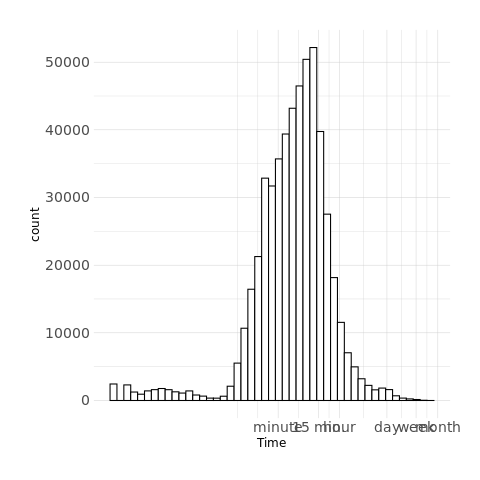

In [264]:
%%R -i r_session_info

r_session_info %>% mutate(
        session_start = ymd_hms(session_start_ts),
        session_end = ymd_hms(session_end_ts),
        session_length = session_end - session_start
    ) %>% filter(session_length > 0) %>%
    ggplot(aes(x = as.numeric(session_length))) + 
      geom_histogram(binwidth = 0.2, colour="black", fill='white') +
  scale_x_log10(
    "Time",
    breaks=c(60, 15*60, 60*60, 24*60*60, 7*24*60*60, 30*24*60*60, 365*24*60*60),
    labels=c("minute", "15 min.", "hour", "day", "week", "month", "year")) +
    commons_theme()

This looks fairly well-distributed on a log-scale, so let's use the median.

In [253]:
session_info['session_start'] = session_lengths['session_start_ts'].apply(parse_dt)
session_info['session_end'] = session_lengths['session_end_ts'].apply(parse_dt)
session_info['session_length'] = session_lengths['session_end'] - session_lengths['session_start']
session_info['session_start_date'] = session_lengths['session_start'].apply(lambda x: x.date())

In [254]:
session_lengths.loc[(session_lengths['session_start_date'] < today) &
                    (session_lengths['session_start_date'] >= last_week)]['session_length'].median()

Timedelta('0 days 00:00:48.148500')

## Click-through rate

Per the [data scientist takehome task](https://github.com/nettrom/Contributors-Hiring-DataScientist-2018), the Search Team defines the click-through rate as the "proportion of search sessions where the user clicked on one of the results displayed."

We're again limiting this to non-bot sessions with less than 50 searches made.

Calculate the average click-through rate:

In [255]:
round(100 * session_info['clicked_through'].mean(), 2)

71.55

## Average position of clicked result in successful searches

In [265]:
## Position can't be -1 (that means it's missing), and the maximum number
## of results is 500, so it can't be above that either.

session_info.loc[(session_info['clicked_through'] == 1) &
                 (session_info['position'] < 500) &
                 (session_info['position'] != -1)]['position'].describe()

count    252434.000000
mean         19.342549
std          52.663988
min           0.000000
25%           0.000000
50%           3.000000
75%          13.000000
max         499.000000
Name: position, dtype: float64

The large difference between the mean and median isn't surprising, the bigger values pulls the mean up. In other words, we'll use the median.

In [258]:
## Position can't be -1 (that means it's missing), and the maximum number
## of results is 500, so it can't be above that either.

session_info.loc[(session_info['clicked_through'] == 1) &
                 (session_info['position'] < 500) &
                 (session_info['position'] != -1)]['position'].median()

3.0

## Success rate

Defined as a click-through with a dwell time of at least 10 seconds.

In [257]:
## Same assumptions as before,
## plus removing all sessions with no checkin

round(100 *
  session_info.loc[(session_info['clicked_through'] == 1) &
                   (session_info['position'] < 500) &
                   (session_info['position'] != -1) &
                   (session_info['last_checkin'] >= 10)]['last_checkin'].count() /
 session_info.loc[(session_info['clicked_through'] == 1) &
                  (session_info['position'] < 500) &
                  (session_info['position'] != -1)]['last_checkin'].count(),
     2)

81.35